## Regressão Linear
A regressão linear é um método estatístico comumente utilizado em aprendizado de máquina e análise de dados que pode ser aplicado para prever coordenadas de latitude e longitude para uma determinada localização. Neste contexto, a regressão linear tem como objetivo estabelecer uma relação linear entre as características de entrada (como medições de intensidade de sinal ou outros parâmetros relevantes) e as variáveis-alvo, que são os valores de latitude e longitude.

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from branca.element import Figure
import folium


In [79]:
# Carregando os dados
df = pd.read_csv("../../project_files/03_processed_files/meds_train_alunos.csv")


In [80]:
X = df[['rssi_1_1', 'rssi_1_2', 'rssi_1_3', 'rssi_2_1', 'rssi_2_2', 'rssi_2_3', 'rssi_3_1', 'rssi_3_2', 'rssi_3_3']]
y = df[['id_ponto','num_lat_bts', 'num_long_bts']]

In [81]:
# Divisão dos dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
# Treinamento do modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [83]:
# Previsões Linear regression
y_pred = model.predict(X_test)

In [84]:
df2 = y_test.copy()
df2['lat_pred'] = [lat for _, lat, _ in y_pred]
df2['lon_pred'] = [lon for _, _, lon in y_pred]


In [85]:
df2['lat_diff'] = df2['num_lat_bts'] - df2['lat_pred']
df2['lon_diff'] = df2['num_long_bts'] - df2['lon_pred']

In [86]:
df2.head()

,id_ponto,num_lat_bts,num_long_bts,lat_pred,lon_pred,lat_diff,lon_diff
5997,9133,-8.048630,-34.952930,-8.049924,-34.952628,0.001294,-0.000302
4882,4445,-8.055506,-34.951693,-8.056214,-34.952587,0.000708,0.000894
2955,6593,-8.055786,-34.951505,-8.054974,-34.951361,-0.000812,-0.000144
2303,9502,-8.047130,-34.950590,-8.049603,-34.952317,0.002473,0.001727
496,8192,-8.051920,-34.947800,-8.052539,-34.946846,0.000619,-0.000954


In [87]:
df2['lat_diff_metros'] = df2['lat_diff'] * 30.87 * 1000
df2['lon_diff_metros'] = df2['lon_diff'] * 30.87 * 1000

In [88]:
df2['diff_metros'] = [math.sqrt(lat_diff**2+lon_diff**2) for lat_diff,lon_diff in zip(df2['lat_diff_metros'],df2['lon_diff_metros'])]

In [89]:
df2['diff_metros'].describe()

count    1353.000000
mean       49.866347
std        36.265885
min         2.285480
25%        30.056302
50%        40.565949
75%        60.186248
max       311.710359
Name: diff_metros, dtype: float64

### Mapa de comparação: posições preditas vs. posições reais


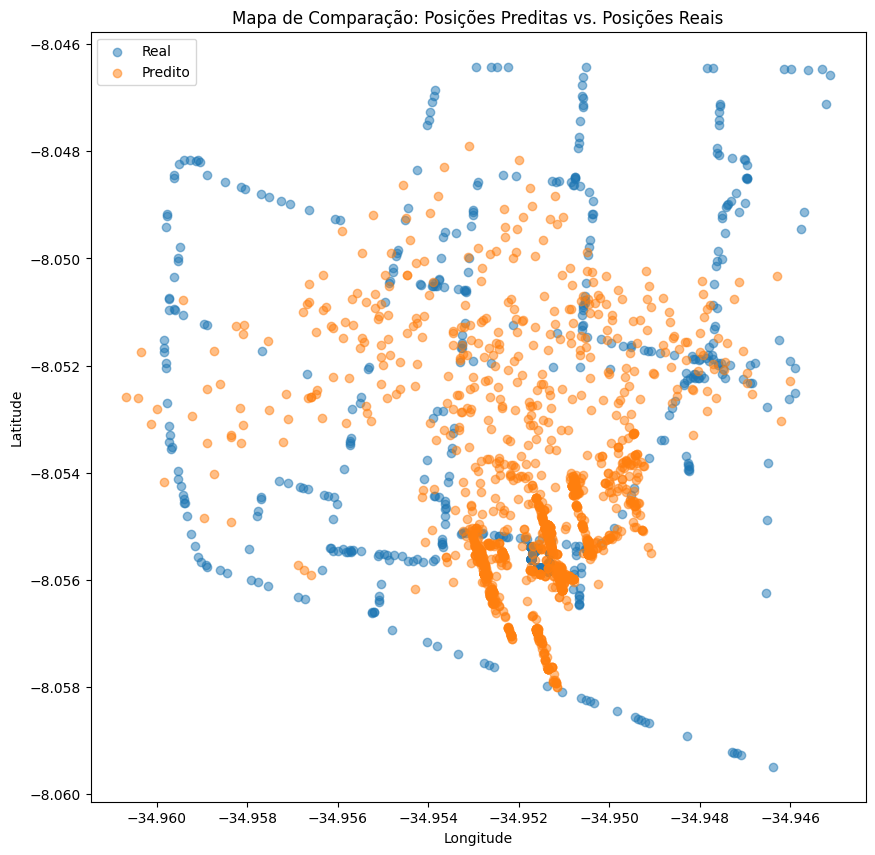

In [90]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test['num_long_bts'], y_test['num_lat_bts'], label='Real', alpha=0.5)
plt.scatter(y_pred[:, 2], y_pred[:, 1], label='Predito', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mapa de Comparação: Posições Preditas vs. Posições Reais')
plt.legend()
plt.show()

In [91]:
os = folium.Map(location=[-8.0556479,-34.9532624], zoom_start=15)

for _, row in df2[['num_lat_bts','num_long_bts']].iterrows():
    folium.CircleMarker(location=[row["num_lat_bts"], row["num_long_bts"]],radius=5, color = 'blue',fill_opacity=0.7).add_to(os)

for _, row in df2[['lat_pred','lon_pred']].iterrows():
    folium.CircleMarker(location=[row["lat_pred"], row["lon_pred"]],radius=5, color = 'orange',fill_opacity=0.3).add_to(os)
os

### Avaliação do Modelo

In [92]:
# Avaliação do modelo
y_test_subset = y_test[['num_lat_bts', 'num_long_bts']]
y_pred_subset = y_pred[:, 1:3]
mse = mean_squared_error(y_test_subset, y_pred_subset)
mae = mean_absolute_error(y_test_subset, y_pred_subset)

In [93]:

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 1.994263793997587e-06
Mean Absolute Error (MAE): 0.001033363561483736


In [94]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Raio da Terra em quilômetros
    R = 6371.0

    # Conversão de graus para radianos
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Diferença entre as coordenadas
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Fórmula de Haversine
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Distância em metros
    distance = R * c * 1000
    return distance
# Calculando as distâncias entre os pontos em y_pred_subset e y_test_subset usando Haversine
errors_haversine = haversine_distance(y_pred_subset[:, 0], y_pred_subset[:, 1], y_test_subset[:, 0], y_test_subset[:, 1])

# Plotando o histograma das distâncias em metros
plt.hist(errors_haversine, bins=20, edgecolor='k')
plt.xlabel('Erro (metros)')
plt.ylabel('Frequência')
plt.title('Histograma dos Erros (Haversine)')
plt.show()

InvalidIndexError: (slice(None, None, None), 0)

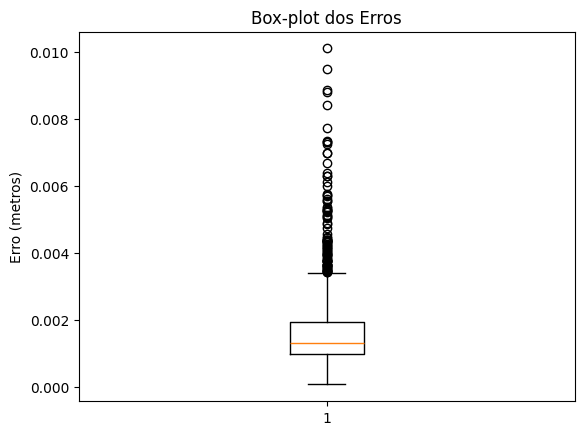

In [ ]:
plt.boxplot(errors_haversine)
plt.ylabel('Erro (metros)')
plt.title('Box-plot dos Erros')
plt.show()

In [ ]:
df_final = df2[['id_ponto', 'lat_pred' ,'lon_pred']]
df_final.to_csv("../../project_files/03_processed_files/Resultados_Equipe1_MetodoLinearRegression.csv")